In [1]:
"""! pip install datasets
! pip install matplotlib
! pip install scikit-learn
! pip install spacy
! pip install nltk
! pip install pattern
# python -m spacy download pt_core_news_sm
# python -m spacy download pt_core_news_lg"""

'! pip install datasets\n! pip install matplotlib\n! pip install scikit-learn\n! pip install spacy\n! pip install nltk\n! pip install pattern\n# python -m spacy download pt_core_news_sm\n# python -m spacy download pt_core_news_lg'

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import load_dataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import re

/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Data Loading and Preprocessing**

In [3]:
dataset = load_dataset("higopires/RePro-categories-multilabel")

In [4]:
# Ver número de exemplos em cada divisão do dataset
for split in dataset.keys():
    print(f"{split}: {len(dataset[split])} examples")

train: 8002 examples
validation: 994 examples
test: 1007 examples


In [5]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

train_data = pd.DataFrame(train_dataset)
val_data = pd.DataFrame(val_dataset)
test_data = pd.DataFrame(test_dataset)

In [6]:
train_data.head()

,review_text,ENTREGA,OUTROS,PRODUTO,CONDICOESDERECEBIMENTO,INADEQUADA,ANUNCIO
0,"Aparelho muito bom, confiável e com valor aqui...",0,0,1,0,0,0
1,"A história é muito boa, porém o autor ""enrolou...",0,0,1,0,0,0
2,"Entrega rápida, produto muito bom Amei. Pratic...",1,0,1,0,0,0
3,Produto otimo so falta o carregador da maquina...,0,0,1,1,0,0
4,a proteção anti queda não é boa se cair de fr...,0,0,1,0,0,0


Checking the missing values 

In [7]:
train_data.isnull().sum()

review_text               0
ENTREGA                   0
OUTROS                    0
PRODUTO                   0
CONDICOESDERECEBIMENTO    0
INADEQUADA                0
ANUNCIO                   0
dtype: int64

Example of some reviews

In [8]:
print(train_data["review_text"][2])

Entrega rápida, produto muito bom Amei. Praticidade


In [9]:
print(train_data["review_text"][7])

...................     ..........gdssdfhhbcxxxxvbjjnvvvvbbbbbvxfvhbbbnncftg


In [10]:
# check data type of review_text
print(type(train_data["review_text"][0]))
# check data type of label PRODUTO
print(type(train_data["PRODUTO"][0]))

<class 'str'>
<class 'numpy.int64'>


In [11]:
"""train_data['length'] = train_data['review_text'].apply(len)
train_data.head()"""

"train_data['length'] = train_data['review_text'].apply(len)\ntrain_data.head()"

In [12]:
# Obter as colunas (nomes dos labels)
columns = list(dataset["train"].features.keys())
labels = columns[1:]  # Excluindo 'review_text'

print("Labels:", labels)
print("Number of labels:", len(labels))

Labels: ['ENTREGA', 'OUTROS', 'PRODUTO', 'CONDICOESDERECEBIMENTO', 'INADEQUADA', 'ANUNCIO']
Number of labels: 6


In [13]:
# Label columns
label_cols = ['ENTREGA', 'OUTROS', 'PRODUTO', 'CONDICOESDERECEBIMENTO', 'INADEQUADA', 'ANUNCIO']

{'PRODUTO': 6258, 'ENTREGA': 2488, 'OUTROS': 1885, 'CONDICOESDERECEBIMENTO': 1369, 'ANUNCIO': 699, 'INADEQUADA': 328}


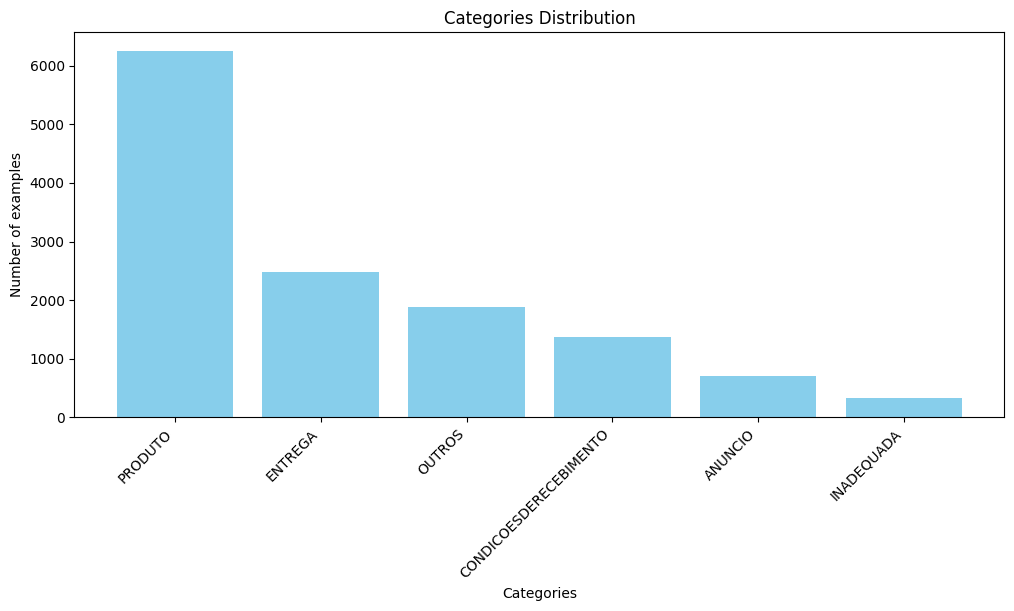

In [14]:
label_counts = train_data.iloc[:, 1:].sum()

# Ordenar por frequência
label_counts = dict(sorted(label_counts.items(), key=lambda item: item[1], reverse=True))

print(label_counts)

# Plotar gráfico
plt.figure(figsize=(12, 5))
plt.bar(label_counts.keys(), label_counts.values(), color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Categories")
plt.ylabel("Number of examples")
plt.title("Categories Distribution")
plt.show()

Number of labels per review distribution:
1    4188
2    2741
3     943
4     122
5       8
Name: count, dtype: int64


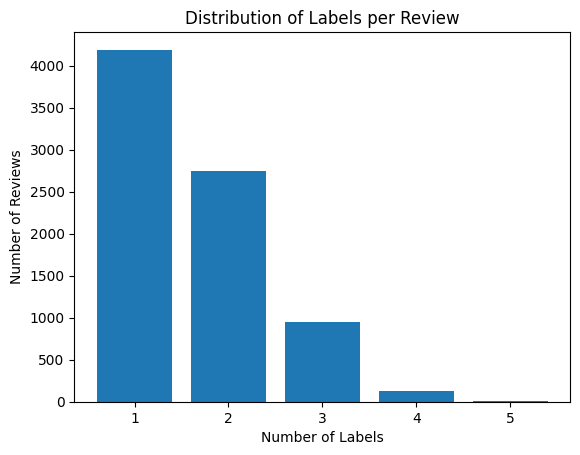

In [15]:
label_counts_per_review = train_data[label_cols].sum(axis=1)
print("Number of labels per review distribution:")
print(pd.Series(label_counts_per_review).value_counts())

plt.hist(label_counts_per_review, bins=range(1, 7), align='left', rwidth=0.8)
plt.title("Distribution of Labels per Review")
plt.xlabel("Number of Labels")
plt.ylabel("Number of Reviews")
plt.show()

* 4188 reviews have exactly 1 label
* 2741 reviews have exactly 2 labels
* 943 reviews have exactly 3 labels
* 122 reviews have exactly 4 labels
* 8 reviews have exactly 5 labels

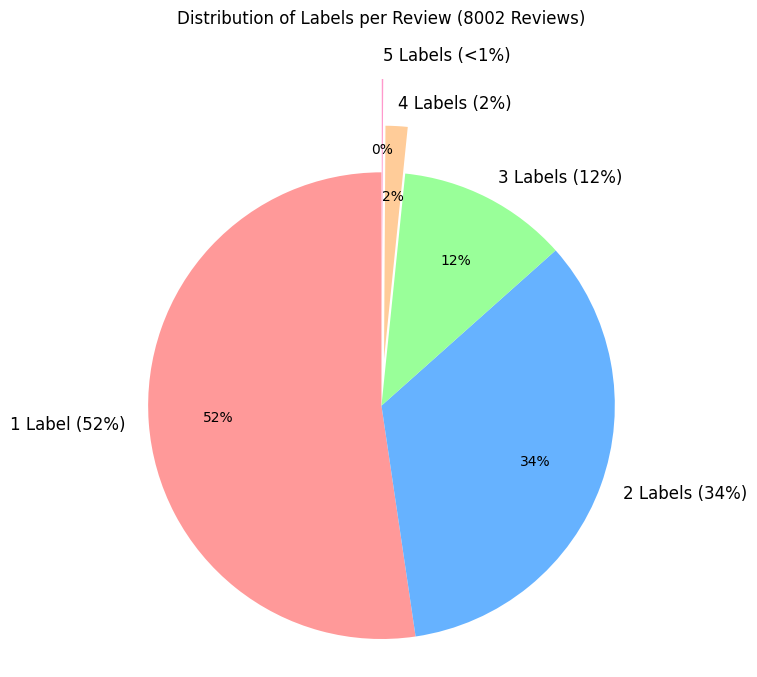

In [16]:
label_counts = label_counts_per_review.value_counts().values
total_reviews = 8002 # number of training examples
percentages = [count / total_reviews * 100 for count in label_counts]
labels = ['1 Label (52%)', '2 Labels (34%)', '3 Labels (12%)', '4 Labels (2%)', '5 Labels (<1%)']

# Create pie chart
plt.figure(figsize=(8, 8))
# Add explode to pull out small slices, and adjust label distance
explode = [0, 0, 0, 0.2, 0.4]  # Pull out 4 and 5 labels a bit
wedges, texts, autotexts = plt.pie(percentages, labels=labels, autopct='%1.0f%%', startangle=90, 
                                   colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC'], 
                                   explode=explode, labeldistance=1.1, pctdistance=0.7)

# Customize text for readability
for text in texts:
    text.set_fontsize(12)  # Bigger label text
for autotext in autotexts:
    autotext.set_fontsize(10)  # Bigger percentage text
    autotext.set_color('black')  # Black for contrast

plt.title("Distribution of Labels per Review (8002 Reviews)", pad=20)
plt.axis('equal')  # Keep it circular
plt.show()

In [17]:
text_lengths = [len(example["review_text"].split()) for example in dataset["train"]]

print(f"Average text length: {np.mean(text_lengths):.2f} words")  
print(f"Maximum text length: {np.max(text_lengths)} words")  
print(f"Minimum text length: {np.min(text_lengths)} words")

Average text length: 24.58 words
Maximum text length: 428 words
Minimum text length: 1 words


In [18]:
# Load the Portuguese language model
nlp = spacy.load('pt_core_news_lg')

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize and lemmatize using spaCy
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Apply preprocessing to the reviews
train_data['cleaned_reviews'] = train_data['review_text'].apply(preprocess_text)
val_data['cleaned_reviews'] = val_data['review_text'].apply(preprocess_text)
test_data['cleaned_reviews'] = test_data['review_text'].apply(preprocess_text)

In [19]:
print("Original text:")
print(train_data['review_text'][0])
print("\nPreprocessed text:")
print(train_data['cleaned_reviews'][0])

Original text:
Aparelho muito bom, confiável e com valor aquisitivo em conta, ou seja: tudo que a massa precisa!

Preprocessed text:
aparelho confiável aquisitivo conta ser massa precisar


## **TF-IDF Vectorization**

Unigram TF-IDF Vectorization

In [20]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features based on your dataset size

# Fit on the training data and transform it into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['cleaned_reviews'])
# Transform the validation and test data using the same vectorizer
X_val_tfidf = tfidf_vectorizer.transform(val_data['cleaned_reviews'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['cleaned_reviews'])

# Check the shape of the TF-IDF features, these are sparse matrices containing the TF-IDF features for the training, validation, and test sets, respectively.
# each row is a document and each column is a word 
"""print("Training data shape:", X_train_tfidf.shape)
print("Validation data shape:", X_val_tfidf.shape)
print("Test data shape:", X_test_tfidf.shape, end="\n\n")"""

# Sum the TF-IDF scores for each word across all documents
tfidf_scores = np.asarray(X_train_tfidf.sum(axis=0)).flatten()

# Get the feature names (words in the vocabulary)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a dictionary of words and their corresponding TF-IDF scores
word_tfidf_scores = dict(zip(feature_names, tfidf_scores))

# Sort the words by their TF-IDF scores in descending order
sorted_words = sorted(word_tfidf_scores.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 words
print("Top 20 unigrams by TF-IDF score:")
for word, score in sorted_words[:20]:
    print(f"{word}: {score:.4f}")

Top 20 unigrams by TF-IDF score:
produto: 515.0546
recomendar: 248.2208
comprar: 213.9742
chegar: 212.4833
prazo: 202.6565
gostar: 194.4167
qualidade: 194.1893
entregar: 190.1552
entrega: 181.2094
rápido: 160.7322
excelente: 158.9161
bom: 153.6764
dia: 151.4586
vir: 142.9737
recebi: 142.9331
super: 125.7680
ótimo: 118.7558
atender: 111.8822
compra: 111.2379
pra: 103.6173


Bigram TF-IDF Vectorization

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Define the TF-IDF vectorizer with unigrams and bigrams
tfidf_bigram = TfidfVectorizer(max_features=5000, ngram_range=(2, 2))  # Unigrams + bigrams

# Fit and transform the training data
X_train_tfidf_bi = tfidf_bigram.fit_transform(train_data['cleaned_reviews'])
# Transform the validation and test data
X_val_tfidf_bi = tfidf_bigram.transform(val_data['cleaned_reviews'])
X_test_tfidf_bi = tfidf_bigram.transform(test_data['cleaned_reviews'])

# Calculate the sum of TF-IDF scores for each feature (word/phrase)
tfidf_scores_bi = np.asarray(X_train_tfidf_bi.sum(axis=0)).flatten()
# Get the feature names (words/phrases)
feature_names_bi = tfidf_bigram.get_feature_names_out()
# Create a dictionary of words/phrases and their corresponding TF-IDF scores
word_tfidf_scores_bi = dict(zip(feature_names_bi, tfidf_scores_bi))
# Sort the words/phrases by their TF-IDF scores in descending order
sorted_words_bi = sorted(word_tfidf_scores_bi.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 unigrams and bigrams by TF-IDF score
print("\nTop 20 bigrams by TF-IDF score:")
for word, score in sorted_words_bi[:20]:
    print(f"{word}: {score:.4f}")


Top 20 bigrams by TF-IDF score:
recebi produto: 95.7412
chegar prazo: 83.8382
gostar produto: 80.2375
produto chegar: 77.7874
entregar prazo: 68.5125
produto entregar: 62.3990
atender expectativa: 60.2666
comprar produto: 53.7249
produto excelente: 53.4997
ótimo qualidade: 53.2209
valer pena: 52.9098
bom produto: 52.2853
produto vir: 51.9831
produto qualidade: 50.8145
super recomendar: 47.4651
produto ótimo: 46.3252
custo benefício: 45.9506
loja americano: 44.6473
produto atender: 44.4668
excelente produto: 44.2356


Unigram + Bigram TF-IDF Vectorization

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Define the TF-IDF vectorizer with unigrams and bigrams
tfidf_bigram = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Unigrams + bigrams

# Fit and transform the training data
X_train_tfidf_bi = tfidf_bigram.fit_transform(train_data['cleaned_reviews'])
# Transform the validation and test data
X_val_tfidf_bi = tfidf_bigram.transform(val_data['cleaned_reviews'])
X_test_tfidf_bi = tfidf_bigram.transform(test_data['cleaned_reviews'])

# Calculate the sum of TF-IDF scores for each feature (word/phrase)
tfidf_scores_bi = np.asarray(X_train_tfidf_bi.sum(axis=0)).flatten()
# Get the feature names (words/phrases)
feature_names_bi = tfidf_bigram.get_feature_names_out()
# Create a dictionary of words/phrases and their corresponding TF-IDF scores
word_tfidf_scores_bi = dict(zip(feature_names_bi, tfidf_scores_bi))
# Sort the words/phrases by their TF-IDF scores in descending order
sorted_words_bi = sorted(word_tfidf_scores_bi.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 unigrams and bigrams by TF-IDF score
print("\nTop 20 unigrams + bigrams by TF-IDF score:")
for word, score in sorted_words_bi[:2000]:
    print(f"{word}: {score:.4f}")


Top 20 unigrams + bigrams by TF-IDF score:
produto: 397.9442
recomendar: 184.9531
comprar: 181.4826
chegar: 162.0091
gostar: 155.7969
qualidade: 146.8700
prazo: 144.8143
entregar: 140.2032
entrega: 133.6801
bom: 124.6411
dia: 122.2652
vir: 121.7276
excelente: 117.9173
rápido: 116.5107
recebi: 114.0214
super: 95.8461
pra: 91.9058
ficar: 89.7605
ótimo: 89.1564
atender: 87.7731
compra: 87.7575
funcionar: 85.2179
nao: 83.4638
esperar: 78.8825
loja: 75.9805
achar: 75.4360
preço: 74.3752
aparelho: 71.3511
ser: 69.8107
expectativa: 68.7355
bonito: 65.3659
fácil: 63.4192
recebi produto: 62.4480
uso: 62.2618
chegar prazo: 60.5169
problema: 59.2140
celular: 59.1514
site: 57.7941
americana: 56.4640
satisfeito: 56.3280
produto chegar: 55.7112
pequeno: 55.4117
avaliar: 55.2121
perfeito: 53.9611
gostar produto: 52.5966
ter: 52.3305
valer: 51.2255
americano: 50.5271
entregar prazo: 50.2499
adorar: 49.6263
tamanho: 48.5949
defeito: 48.1870
custo: 47.1063
ir: 46.1321
material: 44.9083
pena: 44.5563
pr

There's only single words in the top 20 TF-IDF scores for unigrams + bigrams, because the unigrams have higher TF-IDF scores compared to the bigrams. This can happen if the unigrams are more frequent or carry more weight in the dataset.

For word distribution, we choose TF-IDF with unigrams + bigrams (ngram_range=(1, 2), 5000 features) as it captures both dominant single words (e.g., "produto": 397.94) and contextual phrases (e.g., "chegar prazo") in the RePro dataset. This reflects the mix of 52% single-label and 48% multi-label reviews, providing a comprehensive view of key terms without relying on model performance.

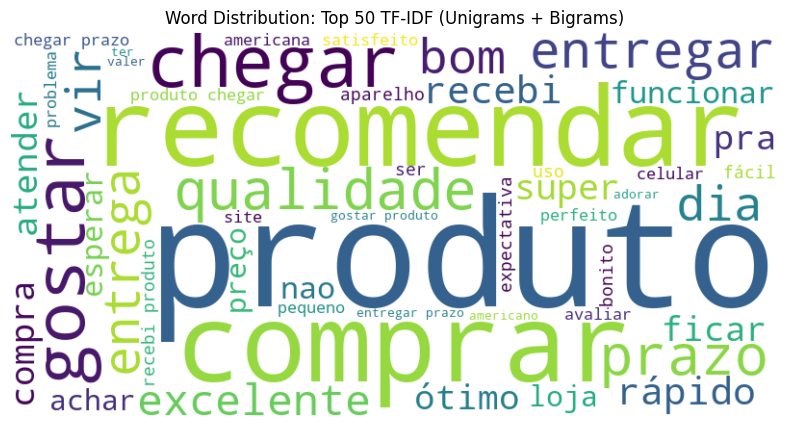

In [23]:
# Word cloud with top 50
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(sorted_words_bi[:50]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Distribution: Top 50 TF-IDF (Unigrams + Bigrams)")
plt.show()

## **Model Training and Evaluation**

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Targets as multi-label arrays (keep one-hot format)
y_train = train_data[label_cols].values  # Shape: (8002, 6)
y_val = val_data[label_cols].values      # Shape: (994, 6)

# Verify multi-label nature
print("Sample training labels (first 5 rows):")
print(y_train[:5])
print("Number of labels per review (first 5):", y_train.sum(axis=1)[:5])

# 1. Unigrams
lr_unigram = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
lr_unigram.fit(X_train_tfidf, y_train)
y_val_pred_uni = lr_unigram.predict(X_val_tfidf)
print("Logistic Regression (Unigrams) - Validation:")
print(classification_report(y_val, y_val_pred_uni, target_names=label_cols))

# 2. Bigrams (ngram_range=(2, 2))
lr_bigram = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
lr_bigram.fit(X_train_tfidf_bi, y_train)
y_val_pred_bi = lr_bigram.predict(X_val_tfidf_bi)
print("Logistic Regression (Bigrams) - Validation:")
print(classification_report(y_val, y_val_pred_bi, target_names=label_cols))

# 3. Unigrams + Bigrams (ngram_range=(1, 2))
tfidf_uni_bi = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf_uni_bi = tfidf_uni_bi.fit_transform(train_data['cleaned_reviews'])
X_val_tfidf_uni_bi = tfidf_uni_bi.transform(val_data['cleaned_reviews'])

lr_uni_bi = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
lr_uni_bi.fit(X_train_tfidf_uni_bi, y_train)
y_val_pred_uni_bi = lr_uni_bi.predict(X_val_tfidf_uni_bi)
print("Logistic Regression (Unigrams + Bigrams) - Validation:")
print(classification_report(y_val, y_val_pred_uni_bi, target_names=label_cols))

Sample training labels (first 5 rows):
[[0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [1 0 1 0 0 0]
 [0 0 1 1 0 0]
 [0 0 1 0 0 0]]
Number of labels per review (first 5): [1 1 2 2 1]
Logistic Regression (Unigrams) - Validation:
                        precision    recall  f1-score   support

               ENTREGA       0.90      0.93      0.92       311
                OUTROS       0.75      0.79      0.77       235
               PRODUTO       0.95      0.91      0.93       782
CONDICOESDERECEBIMENTO       0.72      0.78      0.75       171
            INADEQUADA       0.19      0.50      0.27        42
               ANUNCIO       0.76      0.84      0.80        88

             micro avg       0.83      0.87      0.85      1629
             macro avg       0.71      0.79      0.74      1629
          weighted avg       0.86      0.87      0.86      1629
           samples avg       0.86      0.89      0.86      1629

Logistic Regression (Bigrams) - Validation:
                        precision    r

/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression (Unigrams + Bigrams) - Validation:
                        precision    recall  f1-score   support

               ENTREGA       0.90      0.94      0.92       311
                OUTROS       0.74      0.80      0.77       235
               PRODUTO       0.95      0.90      0.93       782
CONDICOESDERECEBIMENTO       0.75      0.80      0.77       171
            INADEQUADA       0.18      0.48      0.26        42
               ANUNCIO       0.81      0.84      0.83        88

             micro avg       0.83      0.87      0.85      1629
             macro avg       0.72      0.79      0.75      1629
          weighted avg       0.87      0.87      0.86      1629
           samples avg       0.87      0.90      0.86      1629



/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Key Insights**
* **Bigrams Alone (2, 2):** Worst performer across the board—lower macro-F1 (0.61), micro-F1 (0.77), and per-label scores (e.g., ANUNCIO drops to 0.40). The lack of unigrams dilutes the signal (e.g., "produto" at 515.05 vs. "recebi produto" at 95.74).

* **Unigrams:** Strong baseline—high scores for frequent labels (PRODUTO, ENTREGA) and decent macro-F1 (0.74).

* **Unigrams + Bigrams:** Best overall—matches unigrams’ micro-F1 (0.85) and samples-F1 (0.86), but slightly higher macro-F1 (0.75) and boosts CONDICOESDERECEBIMENTO (0.77) and ANUNCIO (0.83).

### Future Work
Sparse TF-IDF (5000 dimensions): Right now, you’re using a method called TF-IDF to turn each review into a list of 5000 numbers. Most of those numbers are zero (that’s why it’s "sparse"), and only a few have values that show which words matter in that review.

Potentially hybrid with Word2Vec later: You could add another method, Word2Vec, which makes a shorter list of numbers (e.g., 100) that capture what words mean. If you mix TF-IDF and Word2Vec together, you get a "hybrid" set of features—some numbers for word importance and some for word meaning.


### Potentially Hybrid with Word2Vec Later
Word2Vec: This is a different way to turn words into numbers. Instead of counting how often words appear (like TF-IDF), it learns what words mean by looking at their context in your reviews.
How it works: It creates a small list of numbers (e.g., 100, called "dimensions") for each word, where similar words (e.g., "entrega" and "chegar") get similar lists.
Example: "comprar" might be [0.2, -0.1, 0.5, ...] (100 numbers), and "compra" might be close to it, like [0.25, -0.08, 0.48, ...].
For a review: You average the Word2Vec lists of all words in a review to get one 100-number list for the whole text.
Dense: Unlike TF-IDF, where most of the 5000 numbers are zero (sparse), Word2Vec’s 100 numbers are all non-zero (dense), packed with meaning.
Hybrid: You can combine TF-IDF and Word2Vec:
Take your TF-IDF list (5000 numbers, sparse).
Add your Word2Vec list (100 numbers, dense).
Result: A 5100-number list per review, mixing word importance (TF-IDF) and word meaning (Word2Vec).
Why? TF-IDF catches key words (e.g., "atrasada" for ENTREGA), while Word2Vec catches relationships (e.g., "atrasada" is like "tarde").

### How This Ties to Model Choice
Current (TF-IDF Only): Logistic Regression or SVM loves sparse TF-IDF because they’re designed for high-dimensional, sparse data.
Hybrid (TF-IDF + Word2Vec): Random Forest or XGBoost might shine because they handle mixed sparse + dense features well, capturing both frequency and semantics.
For now, your dataset uses sparse TF-IDF (5000 dimensions). Adding Word2Vec later could boost performance if your baseline struggles—say, if macro-F1 is low due to label overlap (e.g., ENTREGA vs. CONDICOESDERECEBIMENTO).